# A Brief Demonstration of Varies Gradient Descents Algorithms Using Theano. 

For simplicity we will be applying varies descent algorithms on a linear regression problem. We begin by creating a helper function that will allow us to create data in $\mathbb{R}^3$. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(196)

def gen_data(num_points=196, slope1=1, slope2=1, slope3=1, bias=10, x_max=100):
    weights = np.array([slope1, slope2, slope3], dtype=np.float32)
    f = lambda x: np.dot(weights, x.T) + bias
    data = np.zeros(shape=(num_points, 4), dtype=np.float32)

    for i in range(num_points):
        x_values = rng.uniform(low=0, high=1.0, size=(1, 3)) * x_max
        y_value = f(x_values) + rng.normal(scale=3.0)
        data[i, :-1] = x_values
        data[i, -1] = y_value

    return data

We randomly choose our slopes to be $slope1 = -1, slope2 = 2, slope3 = 1$ and display some of the results.

In [2]:
data = gen_data(slope1=-1, slope2=2, slope3=1)
print(data[:5]) # First 5 data points

[[  68.95092773   57.79753876    4.96865654   61.70221329]
 [  40.92610931   75.10242462   51.93205643  167.21731567]
 [  98.33483887   97.13296509   35.00722885  146.00294495]
 [  23.24506378   43.75597382   58.97801971  137.05874634]
 [  44.54161453   63.20769882   92.87348938  183.66407776]]


We proceed by dividing the data into a training set and validation set. To verify that everything is working correctly we use `linear_model.LinearRegression()` which is previously imported from `sklearn`.

In [4]:
training_data, validation_data = train_test_split(data, test_size=68, random_state=45)
# using sklearn to predict the weights and bias

inputs = training_data[:, :-1]
results = training_data[:, -1]
reg = linear_model.LinearRegression()
reg.fit(inputs, results)
print('The weights are {}, and the bias is {}'.format(reg.coef_, reg.intercept_))

The weights are [-0.99991047  2.0103395   1.01298428], and the bias is 8.567138083903501


## Gradient descents using Theano

In [5]:
import theano
import theano.tensor as T

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/lukas/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/tmpubpqi2ky/m91973e5c136ea49268a916ff971b7377.lib and object C:/Users/lukas/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/tmpubpqi2ky/m91973e5c136ea49268a916ff971b7377.exp

Using gpu device 0: GeForce 940M (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5005)


We began by importing the necessary modules. We define the symbolic variables below, since the data is given as a matrix and the output as a vector then we define them accordingly. The weights and bias are initialized randomly from a uniform distribution. We require to the weights and bias to be changed on each epoch, as such we declare them as shared variables.

In [6]:
rng = np.random.RandomState(1945)

# Paramater initialization
# Symbolic variable
X = T.matrix(name='X', dtype=theano.config.floatX)
y = T.vector(name='y', dtype=theano.config.floatX)
lr = T.scalar(name='learn_rate', dtype=theano.config.floatX)

# Variables that will be updated, hence are declared as `theano.share`
theta = theano.shared(name='theta', 
                      value=rng.uniform(-1, 1, size=(3))
                        .astype(theano.config.floatX))
bias = theano.shared(name='bias',
                     value=rng.uniform(0, 20, size=(1, 1))
                        .astype(theano.config.floatX),
                     broadcastable=(False, True))

### Feed forward

To feed the data forward <b>in this case</b> all that needs to be done is to introduce a cost function. We begin by specifying a cost and creating `cost_f` which will create a theano function that takes in our data (which is symbolically defined to be $X$)  and our results (which is symbolically defined to be $y$) and outputs the cost. `allow_input_downcast=True` will downcast our 64-bit values into 32-bits.   

In [7]:
# Feedforward Pass
cost = T.mean((T.dot(theta, X.T) + bias - y)**2)/2

cost_f = theano.function(inputs=[X, y], outputs=cost,
                         allow_input_downcast=True)

The advantage of using Theano is that it computes the gradients for us. We simply need to specify the function and the paramaters we are diferenting with restpect to. 

In our case we begin by defining the paramaters that we want to take the gradient with respect to, namely `theta` and `bias`. We proceed by taking the gradient of the cost function with respect to those paramaters and finally specifying how to change `theta` and `bias` (for simplicity we will be applying <b>vanilla gradient descent</b> and different approaches are presented near the end).

In [8]:
params = [theta, bias]
# Backward Pass
gradients = T.grad(cost, wrt=params)
updates = [(p, p-lr*g) for p, g in zip(params, gradients)]

The final stage before building our model is to declare a training function and validation function. In our case `val_cost` is the same as `cost_f` but this is not always the case and for completeness we include it here. 

`train` takes in our data, our results, and our learning rate as its inputs, since we want it to output our `cost` we set it `outputs=cost`, finally we specify how we want our shared variables `weights` and `bias` to be <b>updated</b> after every iteration.   

In [9]:
# Theano functions
train = theano.function(inputs=[X, y, lr], outputs=cost,
                        updates=updates,
                        allow_input_downcast=True)

val_cost = theano.function(inputs=[X, y], outputs=cost,
                           allow_input_downcast=True)

### Building the model

Our model needs to take in the training data, the validation data, a learing rate, and the total number of epochs. We will also include arguments for mini batch size and a variation of early stopping which takes into account the mean of the previous values before determining whether to continue. 

In [12]:
# Main model 
def train_model(training_data, validation_data=None, learning_rate= 0.0001,
                epochs=100, mini_batch_size=20, patience=3, tolerance=0.05,
                display_results=True):

    total_values = len(training_data)
    # Best results
    best_loss_train, best_loss_val = np.inf, np.inf
    best_weights_train, best_weights_val = None, None
    best_bias_train, best_bias_val = None, None
    iteration_train, iteration_val = None, None
    # Average validation loss, used for early stoppign
    val_loss_list = np.zeros(patience)

    training_losses, validation_losses = [], []

    for epoch in range(epochs):
        np.random.shuffle(training_data)
        mini_batches = [training_data[k: k+mini_batch_size]
                        for k in range(0, total_values, mini_batch_size)]

        av_loss = 0 

        for mini_batch in mini_batches:
            inputs = mini_batch[:, :-1]
            outputs = mini_batch[:, -1] # this gives it shape (n, ) instead of (n, 1)

            train_loss = train(inputs, outputs, learning_rate)
            av_loss += train_loss/len(mini_batch)

        training_losses.append(av_loss)

        if np.any(validation_data):
            val_input = validation_data[:, :-1]
            val_output = validation_data[:, -1]

            val_loss = val_cost(val_input, val_output)
            validation_losses.append(val_loss)

            if val_loss < best_loss_val:
                best_loss_val = val_loss
                best_weights_val = theta
                best_bias_val = bias
                iteration_val = epoch

            val_loss_list[:-1] = val_loss_list[1:]
            val_loss_list[-1] = val_loss

            if (patience > 0 and
                epoch > patience and
                (np.mean(val_loss_list)/best_loss_val)-1 < tolerance):

                if display_results:
                    print('Breaking on epoch: {}, returning a loss: {}'
                          .format(epoch, val_loss))
                    print(best_weights_val.get_value(), best_bias_val.get_value())
                    print('---------------')
                break

        if av_loss < best_loss_train:
            best_loss_train = av_loss
            best_weights_train = theta
            best_bias_train = bias
            iteration_train = epoch

    if display_results:
        print('The best validation result occured on epoch: {}, resulting in a'
              ' loss of {} and yielding weights of {} and a bias of: {}'\
              .format(iteration_val, best_loss_val, 
                      best_weights_val.get_value(), best_bias_val.get_value()))
        print('==============================================================')
        print('The best training result occured on epoch: {}, resulting in a '
              'loss of {} and yielding weights of {} and a bias of: {}'\
              .format(iteration_train, best_loss_train, 
                      best_weights_train.get_value(), 
                      best_bias_train.get_value()))

    return training_losses, validation_losses, epoch

#### Running the model

In [13]:
t_loss, v_loss, _ = train_model(training_data, validation_data, learning_rate= 0.0001)

Breaking on epoch: 8, returning a loss: 5.1543869972229
[-0.97655553  2.01807594  1.02726543] [[ 7.05619812]]
---------------
The best validation result occured on epoch: 8, resulting in a loss of 5.1543869972229 and yielding weights of [-0.97655553  2.01807594  1.02726543] and a bias of: [[ 7.05619812]]
The best training result occured on epoch: 7, resulting in a loss of 2.026739329099655 and yielding weights of [-0.97655553  2.01807594  1.02726543] and a bias of: [[ 7.05619812]]


The model functions as expected, all that would remain is to cross validate our results with a test set.

#### Displaying the results

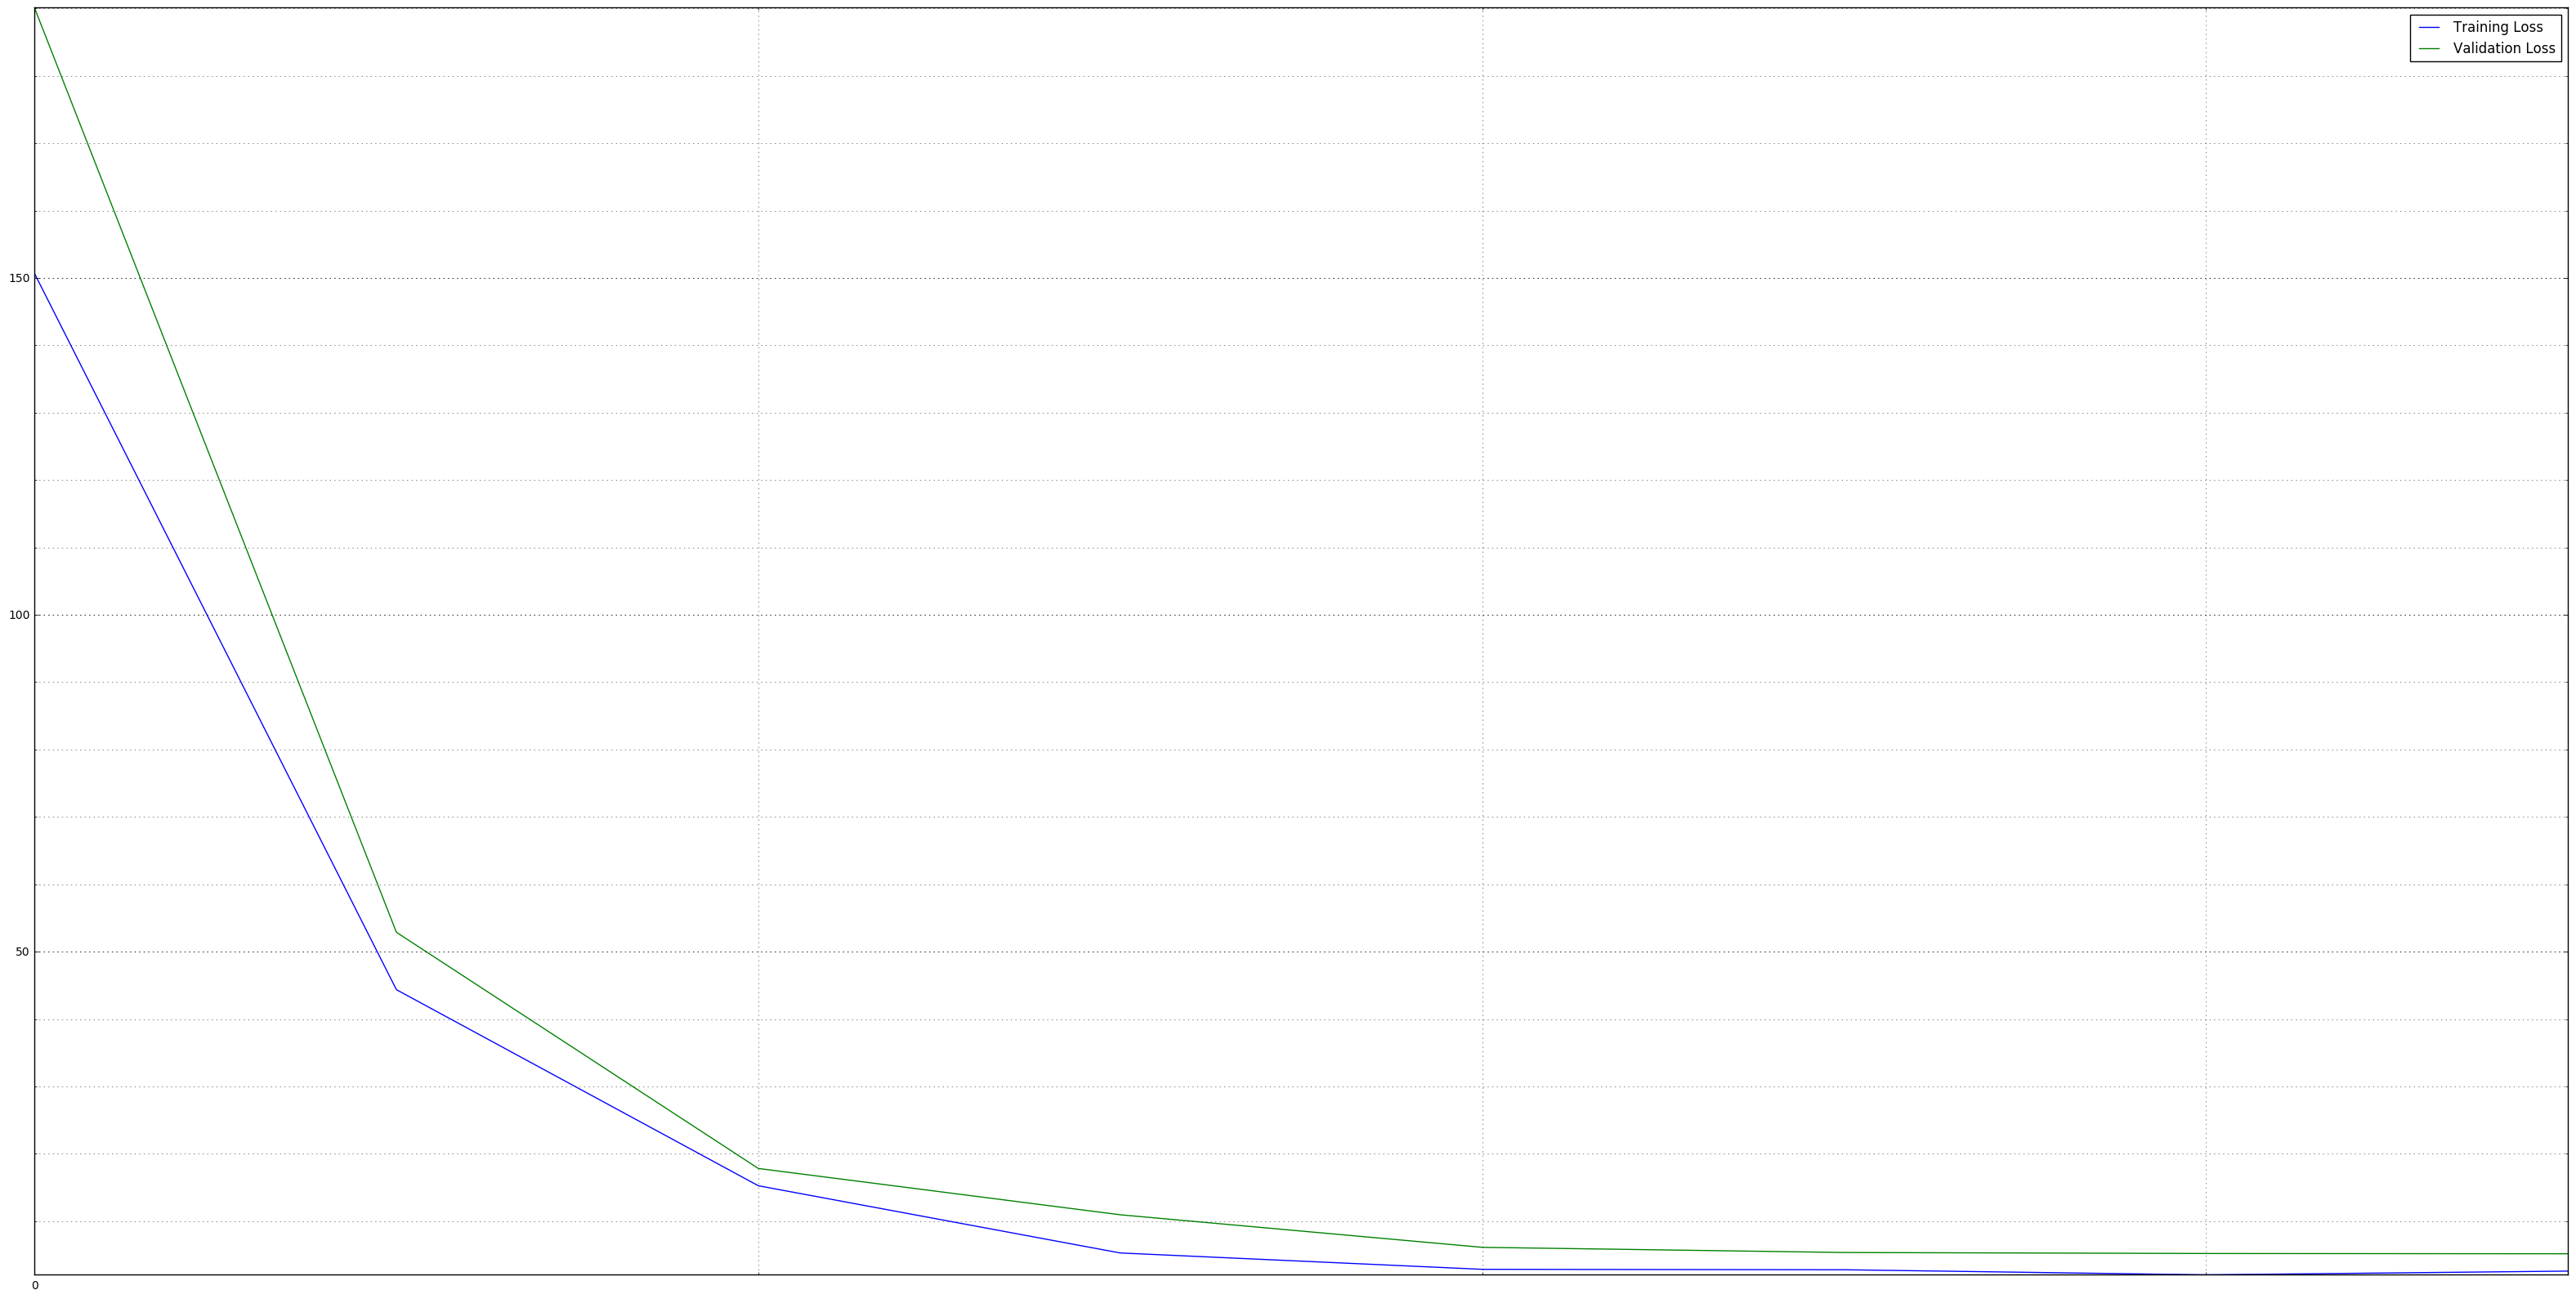

In [14]:
m = 1
x = np.arange(len(t_loss[m:]))

fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(1, 1, 1) 
                                   
major_ticks_x = np.arange(0, 40, 10)                                              
minor_ticks_x = np.arange(0, 40, 2)
major_ticks_y = np.arange(0, 450, 50)                                              
minor_ticks_y = np.arange(0, 450, 10)

ax.set_xticks(major_ticks_x)                                                       
ax.set_xticks(minor_ticks_x, minor=True)                                           
ax.set_yticks(major_ticks_y)                                                       
ax.set_yticks(minor_ticks_y, minor=True) 

ax.grid(which='both')
ax.grid(which='minor', alpha=0.7)                                                
ax.grid(which='major', alpha=1.0)    

t_plot = plt.plot(x, t_loss[m:], label='Training Loss')
v_plot = plt.plot(x, v_loss[m:], label='Validation Loss')                                            

plt.legend(loc='upper right')
plt.show()

#### Using an ensemble

Since the model is tiny we could run it multiple times in a relatively short period of time and average out the results for our `weights` and `bias`.

In [16]:
weights_ens, bias_ens, epochs = 0, 0, 0
n = 50
for i in range(n):
    _, _, epoch = train_model(training_data, validation_data,
                              display_results=False)

    epochs += epoch

    weights_ens += theta.get_value()
    bias_ens += bias.get_value()

    theta_reset = np.random.uniform(-1.0, 1.0, size=(3))\
                    .astype(theano.config.floatX)
    bias_reset = np.random.uniform(0, 20.0, size=(1, 1))\
                        .astype(theano.config.floatX)
    theta.set_value(theta_reset)
    bias.set_value(bias_reset)

print('Ensemble weights: {}, ensemble bias: {}, average number of epochs: {}'
      .format(weights_ens/n, bias_ens/n, epochs/n))

Ensemble weights: [-1.00074041  1.99638164  1.00512218], ensemble bias: [[ 10.45480061]], average number of epochs: 10.04


We see that that running our results yields a more accurate result to the true values.

## Different Descent Methods

### Momentum and Nestorov momentum

For momentum and Nestorov momentum we need to include a momentum paramater, in addition to velocities for the weights and biases. The only difference between the two is the update rule. Again since the velocities need to be changed after each epoch we declare them as `shared variables`.

In [12]:
# Momentum and NAG parameters
mu = T.scalar(name='momentum', dtype=theano.config.floatX)
v_theta = theano.shared(name='velocity_theta', 
                        value=np.zeros(3, dtype=theano.config.floatX))
v_bias = theano.shared(name='velocity_bias',
                       value=np.zeros((1, 1), dtype=theano.config.floatX),
                       broadcastable=(True, True))

vel = [v_theta, v_bias]

Update rule for <b>momentum</b> 

In [13]:
def momentum_update(param, velocity, df):
    v_next = mu * velocity - lr * df
    updates = (param, param+v_next), (velocity, v_next)

    return updates

Update rule for <b>Nestorov momentum</b>

In [14]:
def nag_update(param, velocity, df):
    v_prev = velocity
    v = mu * velocity - lr * df
    x = mu * v_prev + (1-mu) * v
    updates = (param, param+x), (velocity, v)

    return updates

Finally, in both cases the updates for all the paramaters are preformed as follows:

In [15]:
updates = []
for p, v, g in zip(params, vel, gradients):
    param_updates, vel_updates = momentum_update(p, v, g) # or nag_update
    updates.append(param_updates)
    updates.append(vel_updates)

#### ADAGrad and RMSProp 

ADAGrad and RMSProp are very similar, the difference being that RMSProp has a decay rate. Both methods used historical gradient information to help with convergence

In [16]:
eps = T.scalar(name='eps', dtype=theano.config.floatX)
dr = T.scalar(name='decay_rate', dtype=theano.config.floatX) # only for RMSProp

# Cache
cache_theta = theano.shared(name='cache_theta', 
                            value=np.zeros(3, dtype=theano.config.floatX))
cache_bias = theano.shared(name='cache_bias',
                           value=np.zeros((1, 1), dtype=theano.config.floatX),
                           broadcastable=(False, True))

caches = [cache_theta, cache_bias]

update rule for <b>ADAGrad</b>

In [17]:
def adagrad_update(param, cache, df):
    cache_val = df**2
    x = lr * df / (T.sqrt(cache_val) + eps)
    updates = (param, param-x), (cache, cache+cache_val)

    return updates

update rule for <b>RMSProp</b>

In [18]:
def rmsprop_update(param, cache, df):
    cache_val = dr * cache + (1-dr) * df**2
    x = lr * df / (T.sqrt(cache_val) + eps)
    updates = (param, param-x), (cache, cache_val)

    return updates

Finally, in both cases the updates for all the paramaters are preformed as follows:

In [19]:
updates = []
for p, c, g in zip(params, caches, gradients):
    param_updates, cache_updates = adagrad_update(p, c, g)
    updates.append(param_updates)
    updates.append(cache_updates)

#### ADAM

ADAM can be thought of as RMSProp with momentum.

In [20]:
# ADAM Parameters
beta1 = T.scalar(name='beta1', dtype=theano.config.floatX)
beta2 = T.scalar(name='beta2', dtype=theano.config.floatX)
eps = T.scalar(name='eps', dtype=theano.config.floatX)
t = theano.shared(name='iteration', value=np.float32(1.0))
one = T.constant(1)
m_theta = theano.shared(name='moment_theta',
                        value=np.zeros(3, dtype=theano.config.floatX))
m_bias = theano.shared(name='moment_bias',
                       value=np.zeros((1, 1), dtype=theano.config.floatX),
                       broadcastable=(False, True))
v_theta = theano.shared(name='velocity_theta',
                        value=np.zeros(3, dtype=theano.config.floatX))
v_bias = theano.shared(name='velocity_bias',
                       value=np.zeros((1, 1), dtype=theano.config.floatX),
                       broadcastable=(False, True))

moments = [m_theta, m_bias]
vel = [v_theta, v_bias]

update rule for ADAM

In [21]:
def adam_update(param, moment, velocity, df):
    m_t = beta1 * moment + (one-beta1) * df
    v_t = beta2 * velocity + (one-beta2) * df**2
    m_hat = m_t/(one-beta1**(t))
    v_hat = v_t/(one-beta2**(t))
    x = (lr * m_hat / (T.sqrt(v_hat) + eps))
    updates = (param, param-x), (moment, m_t), (velocity, v_t)

    return updates

updating the paramaters:

In [22]:
updates = []
for p, m, v, g in zip(params, moments, vel, gradients):
    p_update, m_update, v_update = adam_update(p, m, v, g)
    updates.append(p_update)
    updates.append(m_update)
    updates.append(v_update)
updates.append((t, t+1))

#### ADAMax

ADAMax is a variation of ADAM using the inf-norm

In [19]:
# ADAMax Parameters
beta1 = T.scalar(name='beta1', dtype=theano.config.floatX)
beta2 = T.scalar(name='beta2', dtype=theano.config.floatX)
t = theano.shared(name='iteration', value=np.float32(1.0))
one = T.constant(1.0)
m_theta = theano.shared(name='moment_theta',
                        value=np.zeros(3, dtype=theano.config.floatX))
m_bias = theano.shared(name='moment_bias',
                       value=np.zeros((1,1), dtype=theano.config.floatX),
                       broadcastable=(False, True))
u_theta = theano.shared(name='up_theta',
                        value=np.zeros(3, dtype=theano.config.floatX))
u_bias = theano.shared(name='up_bias',
                       value=np.zeros((1, 1), dtype=theano.config.floatX),
                       broadcastable=(False, True))

moments = [m_theta, m_bias]
upd = [u_theta, u_bias]

Update rule for ADAMax

In [20]:
def adamax_update(param, moment, u, df):
    m_t = beta1 * moment + (one-beta1) * df
    u_t = T.maximum(beta2*u, T.abs_(df))
    x = (lr/(1-beta1**t)) * (m_t/u_t) 
    updates = (param, param-x), (moment, m_t), (u, u_t)

    return updates

Updating the parameters:

In [21]:
updates = []
for p, m, u, g in zip(params, moments, upd, gradients):
    p_update, m_update, u_update = adamax_update(p, m, u, g)
    updates.append(p_update)
    updates.append(m_update)
    updates.append(u_update)
updates.append((t, t+1))